In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [2]:
# read in dataset Jill
dset = pd.read_csv('08_09_2016_CC_Subject3.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))

This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 
It performs the following tasks: 

1) Exponential smoothing of the raw data: removes fast oscillations in the data (chest) by calculating exponentially weighted moving average (cesm), where data further in the past is weighted exponentially less. Current decay time: 20 samples (1s).
   
2) Calculates 'long-term' moving average:  (cmav). Current averaging time: 7*20 samples (7s) 

3) Subtracts long-term average from smoothened data: (del) this removes dynamics slower than 7s, correcting for drift

4) Detect breath phase: (ph1) +1 if sensor stretched more than average -1 if sensor stretched less than average.

5) Detect breath phase changes: (ph1_slp) +1 where phase changes (-1 to +1) and -1 where phase changes from (+1 to -1). 0 elsewhere.

6) Based on (5), store the last N rise times and fall times, where currently N = 20.

7) Based on (6) calculate breath times based on successive rises and successive falls
 
Motivation: Fourier Analysis is a very robust method for analyzing the periodicity of a signal. Its precision however depends on the number of wave cycles that the fourier transform is performed over, meaning that it can be run meaningfully only over a sample window including several breath cycles (*).
 
(1)   Frequency Analysis means that changes in breath rate faster than the sampling window will be averaged out, while breath cycles longer than the sampling window will not register. This introduces a trade-off (which can probably be optimized by dynamically adjusting the sampling window, but it won't go away). 
 
A multiple-breath sampling window will be several 10s of seconds long, and the measured breath frequency will trail the actual current breath frequency correspondingly. Changes in breath rate will be smoothened out, with the fastest recognized changes on the time scale of the sample window. More immediate feedback may be desirable for users who want to watch their breaths closely in real-time, or who want to map their breathing during activities where breath rates are subject to relatively rapid changes.
 
(2)   Since breaths are not perfectly periodic, frequency is intrinsically a somewhat loose metric to describe breathing. A more accurate metric is the time taken for each breath (which enable the calculation of breath rates etc.). Detecting individual breaths can give real time feedback about breathing, but it is less stable than Fourier Analysis. Given that it is working reasonably well, the method can be stabilized by averaging over breath cycles and by throwing out bad measurements automatically. The model used here has the advantage of using only two main parameters, namely the averaging time and the offset of the moving average. 
               
               
(*) I haven't tested out the minimum feasible number, but the coarse sampling of the FFT you get from the autocorrelation gives you some idea of the nature of the problem). 

Further work: A functioning detection of breath cycles enables the deduction of all sorts of other quantities of interest, for example the depth of inhaling and exhaling, or the rate/time of breathing in vs. breathing out. It can also serve as a reference for the interpretation of the belly data. The algorithm is reasonably stable as is, my recommendation would be to put some work into stabilizing it further: if you can reliably spot individual breaths in the data, then everything else is easy.
                
The reliability of the algorithm can be improved by (1) dynamical optimization of the detection parameters and (2) automatically identifying and discarding bad data. 
 
(1) can be done via the current breath rate. For example, the time over which a moving average is taking to act as a reference should ideally be subject to the current breath rate.
 
(2) can be done with a probabilistic model. Roughly speaking, this would mean attaching an error bar (i.e. confidence) to each detection. Having a measure of confidence can be used to deal intelligently with outliers. For example, the detection of a 30s breath cycle could either be the result of an erroneous measurement, or it could mean that the user is actually holding their breath. Information about the confidence of a particular measurement allows the algorithm to decide which is the case. A measure for the likelihood of having performed a correct detection can be derived from a comparison to the results of predicitive modeling based on preceeding  breaths (i.e., is this breath cycle much longer/shorter than previous cycles), through comparison across simultaneously detection methods (i.e. time between successive exhales is very different from time between successive inhales), and through monitoring of raw data (i.e. concurrent body movement or large sudden changes in breath sensor data make outliers in the data much more likely to be a result of measurement error)

In [3]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:14000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/20) # add timestamp assuming 20 samples / second
print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 15 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp) 

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-5:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-5:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x

d['rbtime'] = d['rbtime'].apply(repNan)
d['fbtime'] = d['fbtime'].apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

   chest  belly    ax  ay    az    gx    gy    gz  time
0   2247   2074  8742   4  3536  -258 -2564 -1022  0.00
1   2246   2082  8742   4  3536  -410 -2059  -936  0.05
2   2247   2088  8742   4  3536  -996 -2084 -1701  0.10
3   2242   2096  8479   9  3275 -1118 -1961 -1842  0.15
4   2228   2083  8479   9  3275 -2064 -3039 -1952  0.20


In [4]:
f = d

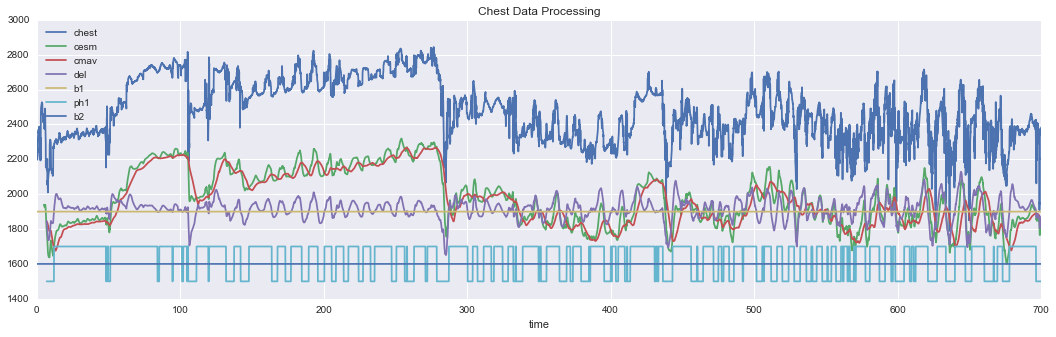

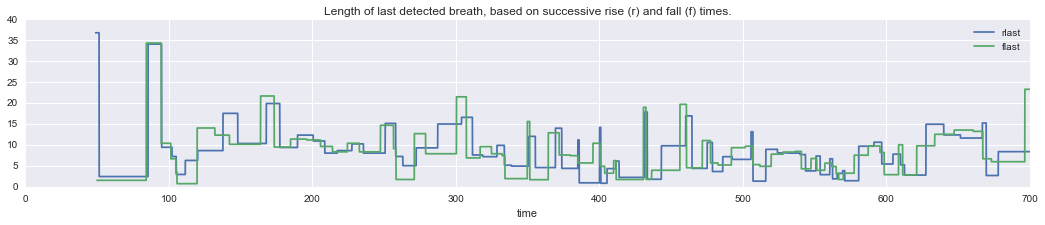

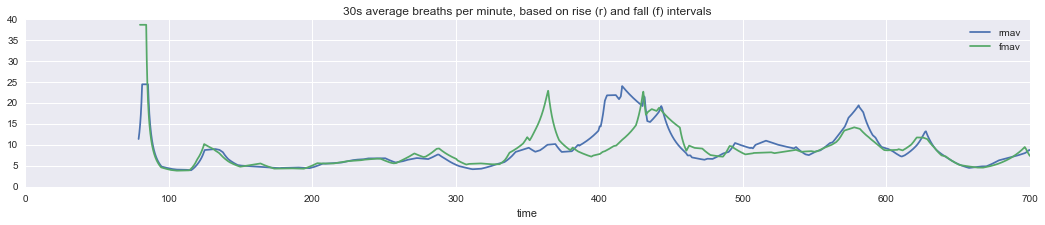

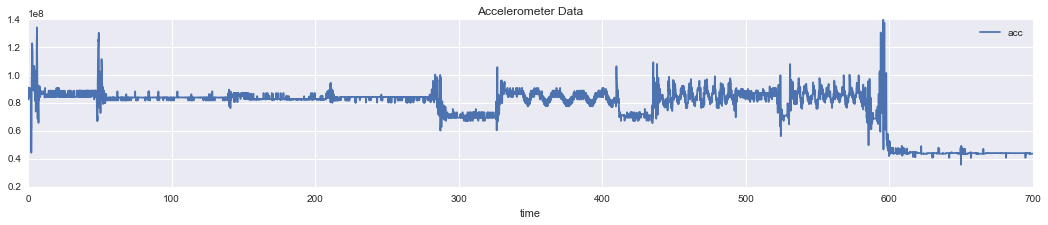

In [5]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 1600
g['b2'] = 1600
g.plot(x = 'time',y = ['chest','cesm','cmav','del','b1','ph1','b2'],figsize = (18,5),title = 'Chest Data Processing')
d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(x = 'time',y = ['rmav','fmav'], figsize = (18,3), title = '30s average breaths per minute, based on rise (r) and fall (f) intervals')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). That is, MovingAverage[X(t_n)] = (1/N)(X(t_n) + X(t_n-1) + ... X(t_n-N)). This is as opposed to a moving average where at each point averaging is performed using the values of the past, the present *and* the future. It is easier to analyze the data when for each data point, the data points that follow in time are already known, but this is obviously not something that can be done in real time. This is something to be kept in mind, however, for situations where it is acceptable that analysis is performed based on data that is a little bit older. For now, everything I coded up is designed to function as close to in real-time as possible. 

Note how differences in the breath length as detected between successive falls and rises are symptomatic of situations where the detection doesn't work well. However, that sort of pattern can be legitimate: a short breath cycle followed by a breath that is held for a long time creates a short time span between successive rises and a very time span between successive falls.

In [6]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly    ax    ay    az    gx    gy    gz   time  ...   \
0          0   2247   2074  8742     4  3536  -258 -2564 -1022    0.0  ...    
1000    1000   2231   2059   276  -287  8745  1003   904  1580   50.0  ...    
2000    2000   2737   2294 -4081   280  8200  -387   152    35  100.0  ...    
3000    3000   2569   2237 -4369  1091  8177  -345   136    10  150.0  ...    
4000    4000   2612   2384 -4384  1094  7915  -394   171    69  200.0  ...    
5000    5000   2674   2439 -4652   551  7904  -422   216    62  250.0  ...    
6000    6000   2461   2149 -7101    -1  4380  -363   269    70  300.0  ...    
7000    7000   2289   2158  9008   -12  2448 -1234  -306  -463  350.0  ...    
8000    8000   2313   2336  8476     7  3808  -626    35    72  400.0  ...    
9000    9000   2399   1972 -2724   551  9020  7834  -351  1034  450.0  ...    
10000  10000   2556   2084 -2463   -13  8748  -435   223  -112  500.0  ...    
11000  11000   2374   2193 -5743     3  6559  -111  